### Daytum +2 Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Simulation Post-processing Demonstration and Exercise

#### Goal

Calculate local uncertainty over an ensemble of spatial models.

#### Description

Here's a simple, documented workflow, demonstration of local uncertainty calculation for subsurface modeling workflows. This should help you get started with building subsurface models that integrate spatial continuity. 

Here's a simple workflow for realization post-processing. Some examples of applications include:

* Quantifying local uncertainty away from wells
* Accessing the probability / risk of specific local outcomes

First let's explain the concept of realization post-processing.

#### Realization Post-processing

Post-processing refers to operations to provide summaries over multiple realizations.

Here will will focus on a few local statistical summaries.  These methods calculate the local cumulative distribution function at each location in the model based on pooling the local realizations.

$$
F_x(\bf{u}_{\alpha})
$$

The following are local summaries demonstrated in this workflow:

* **e-type** is the local expectation (since equal weighted the same as the average)

$$
e(\bf{u}_{\alpha}) = E \{x^{\ell}(\bf{u}_{\alpha}) \}, \quad \forall \quad \ell = 1., \ldots, L, \quad \alpha \in V
$$

* **conditional standard deviation** is the local standard deviation over the realizations


\begin{equation}
\sigma(\bf{u}_{\alpha}) = \sqrt{E \{ (x^{\ell}(\bf{u}_{\alpha})- e(\bf{u}_{\alpha}))^2 \} }, \quad \forall \quad \ell = 1., \ldots, L, \quad \alpha \in V
\end{equation}


* **local percentile** is the local percentile over the realizations

\begin{equation}
x^p(\bf{u}_{\alpha}) = F^{-1}(p)(\bf{u}_{\alpha}), \quad \alpha \in V
\end{equation}

* **local probability of exceedance** is the local percentile over the realizations

\begin{equation}
P \{X(\bf{u}_{\alpha}) \lg x_k \} = 1 - \frac{1}{L} \cdot \sum^{L}_{\ell=1} i^{\ell}(\bf{u}_{\alpha}; z_k), \quad \alpha \in V
\end{equation}

We will calculate multiple realizations and then use each one of these local calculations over the realizations to demonstrate model post-processing.  

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
from intake import cat

#### Declare Functions

These functions read in the multiple realizations and produce local statistical summaries that we will cover below.  They will shortly be added to GeostatsPy.

In [3]:
def local_expectation(realizations):                      # calculate the local expectation / average realization
    cond_exp = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            cond_exp[iy,ix] = np.average(a = realizations[iy,ix,:])  
    return cond_exp

def local_standard_deviation(realizations):               # calculate the local standard deviation of realizations
    local_stdev = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            local_stdev[iy,ix] = np.std(a = realizations[iy,ix,:])  
    return local_stdev
 
def local_percentile(realizations,p_value):               # calculate the local percentile of realizations
    percentile = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            percentile[iy,ix] = np.percentile(a = realizations[iy,ix,:], q = p_value)  
    return percentile

def local_probability_exceedance(realizations,threshold): # calculate the local probability of exceeding a threshold 
    prob_exceed = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            prob_exceed[iy,ix] = np.sum(realizations[iy,ix,:] >= threshold)/realizations[0,0,:].size 
    return prob_exceed

#### Loading Tabular Data

Here's the command to load the Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [4]:
df = cat.sample_data_MV_biased.read()             # read a .csv file in as a DataFrame
df.describe()                                             # summary statistics 
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df.head()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,155,252,800.0,269.0,1.0,0.137710,11.347161,5461.129656
1,79,125,900.0,999.0,1.0,0.130281,4.472919,4282.508020
2,182,294,940.0,159.0,1.0,0.143970,16.261319,4589.005976
3,110,182,260.0,419.0,1.0,0.133234,9.608327,4792.113388
4,190,307,110.0,689.0,1.0,0.144647,26.797640,3478.107639


#### Calculating Multiple Realizations

Let's calculate multiple realizations and visualize a few of them to check.  Note, we need enough realizations to be able to summarize the local uncertainties over the models.  I defaulted to 20, you can reduce this to improve the run time, but the results will be more noisy!


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0253 (close to 0.0?)
                                   variance = 1.0154 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
          

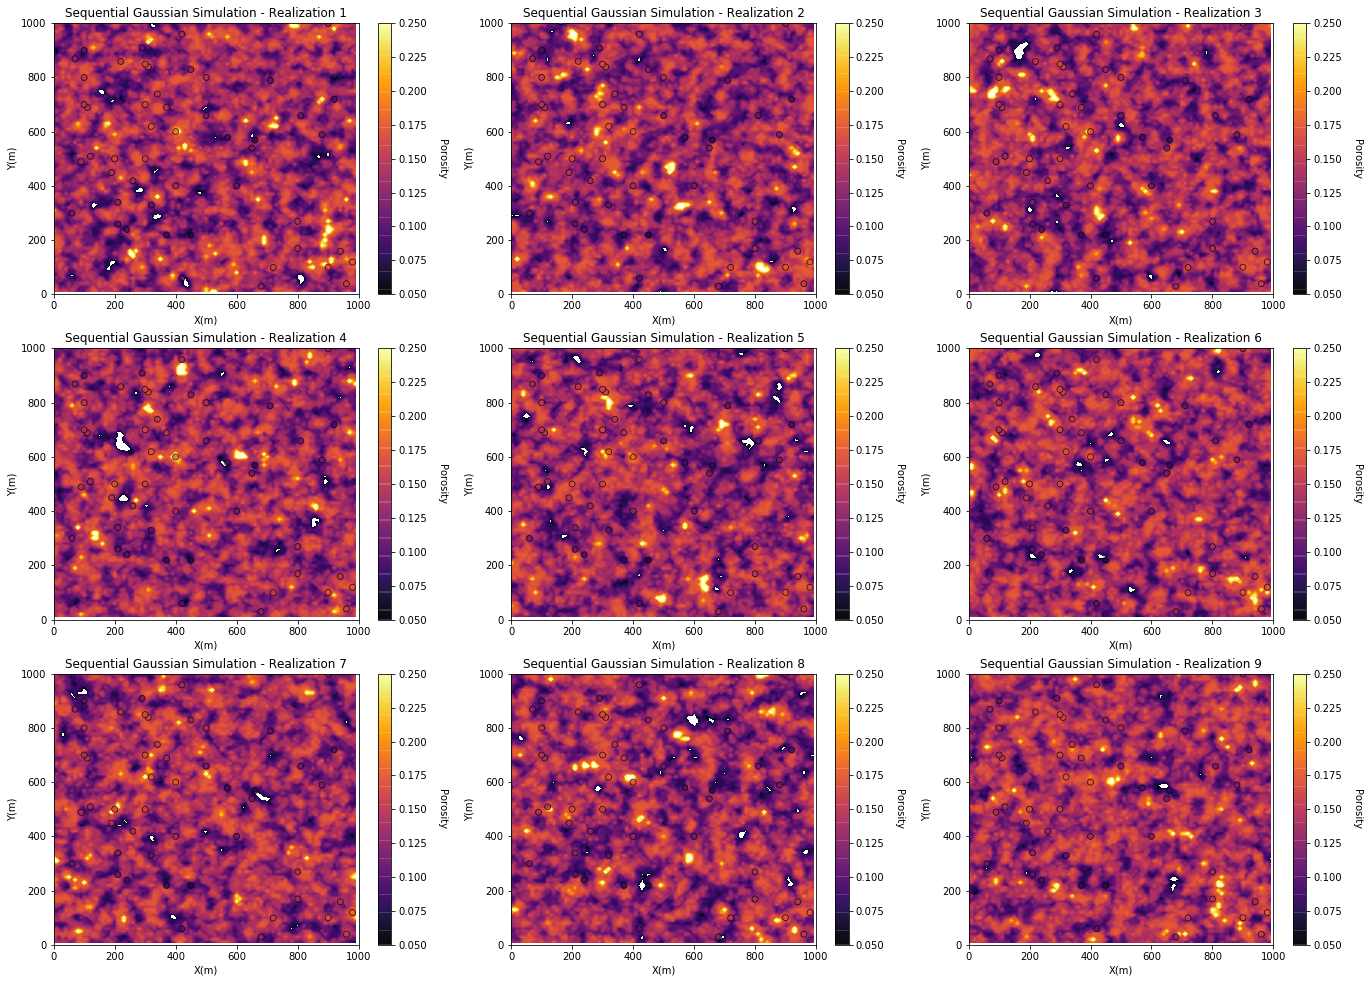

In [5]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

ndmin = 0; ndmax = 10; radius = 50; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)
tmin = -999; tmax = 999

nreal = 20                               # number of bootstrap realizations                             
realizations = np.zeros((ny,nx,nreal));

for ireal in range(0,nreal):
    realizations[:,:,ireal] = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073 + ireal,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

for ireal in range(0,min(nreal,9)):
    plt.subplot(3,3,ireal+1)
    GSLIB.locpix_st(realizations[:,:,ireal],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization ' + str(ireal+1),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()


### Summarizing Local Uncertainty with the POSTSIM Method

Let's run the POSTSIM algorithm. It simply loops over all the locations ix and iy and calculates local summary statistics to quantify the local uncertainty.

#### e-type and Conditional Variance

We will start with the e-type and the conditional variance.  

* **e-type** is the local expectation (just the average of the $L$ realizations at location $\bf{u}_{\alpha}$ as we assume all realizations are equally likely).
* **conditional variance** is the local variance  

Note, we just have to run the program once because both of these outputs are included together.

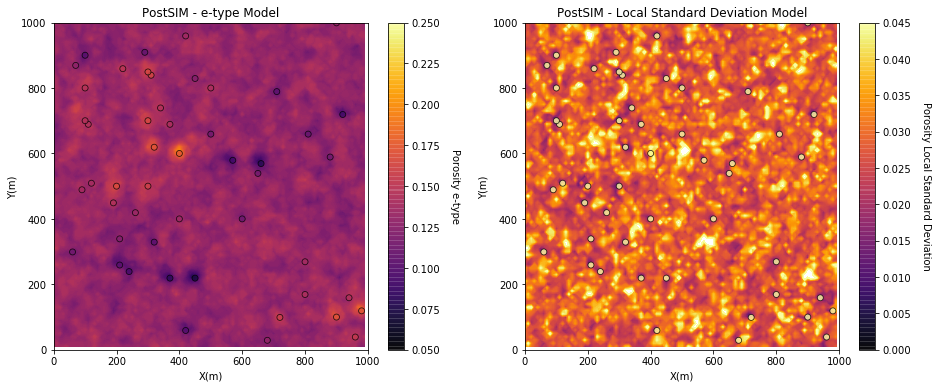

In [6]:
e_type = local_expectation(realizations)
local_stdev = local_standard_deviation(realizations)

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','PostSIM - e-type Model','X(m)','Y(m)','Porosity e-type',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(local_stdev,xmin,xmax,ymin,ymax,xsiz,0.0,0.045,df,'X','Y','Porosity','PostSIM - Local Standard Deviation Model','X(m)','Y(m)','Porosity Local Standard Deviation',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

The e-type model is very simlar to a kriging model, except for:

* the Gaussian forward and back transform may change the results
* result are noisy due to too few realizations

The conditional variance is lowest at the data locations and increased away from the data

* the result is noisy due to too few realizations

#### Local Percentiles

Now let's look at the:

* **local percentile** maps are the maps with the local percentile values sampled from the local realizations

We can interprete them as follows, at a location if we have a local P10 of 14% porosity, then we have a 90% probability of an even higher porosity, the porosity at that location is surely high.

Local percentiles are very convenient to understand local uncertainty.  We must make sure that we do not mix them up with a percentile model (the model that is globally ranked as a specific percentile outcome.

Note: we have to run the program for each percentile, we specify this as the *cdf_value* input.

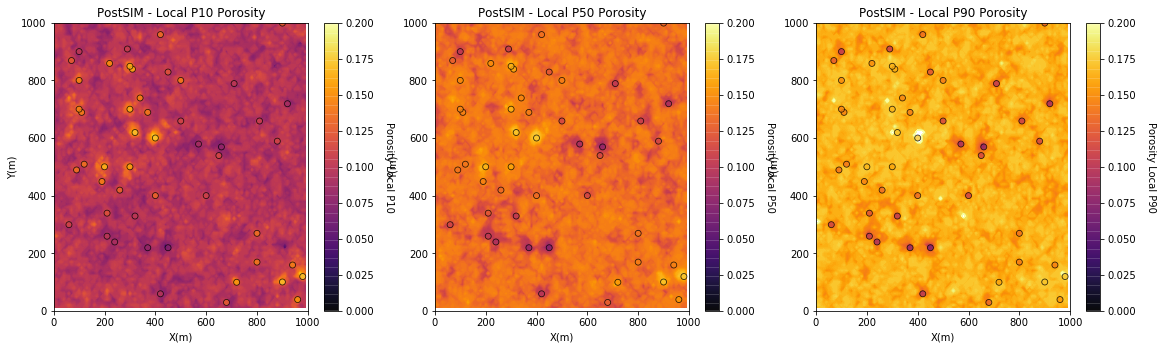

In [7]:

localp10 = local_percentile(realizations = realizations,p_value = 10)

localp50 = local_percentile(realizations = realizations,p_value = 50)

localp90 = local_percentile(realizations = realizations,p_value = 90)


plt.subplot(1,3,1)
GSLIB.locpix_st(localp10,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P10 Porosity','X(m)','Y(m)','Porosity Local P10',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(localp50,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P50 Porosity','X(m)','Y(m)','Porosity Local P50',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(localp90,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P90 Porosity','X(m)','Y(m)','Porosity Local P90',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1., wspace=0.2, hspace=0.2)
plt.show()

#### Probability of Exceedance

Now we will look at the: 

* **probability of exceedance** where we specify a threshold porosity value and calculate the probability of exceeding that value at all locations.

We will typically select critical thresholds, such as a net-to-gross threshold.

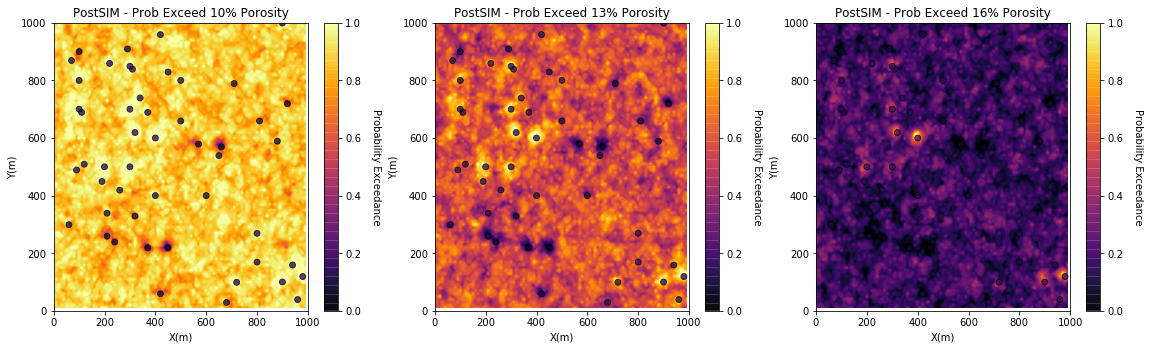

In [8]:

prob10 = local_probability_exceedance(realizations = realizations,threshold = 0.10)

prob13 = local_probability_exceedance(realizations = realizations,threshold = 0.13)

prob16 = local_probability_exceedance(realizations = realizations,threshold = 0.16)

plt.subplot(1,3,1)
GSLIB.locpix_st(prob10,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 10% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(prob13,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 13% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(prob16,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 16% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1., wspace=0.2, hspace=0.2)
plt.show()

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>